# 01_EDA – Análisis Exploratorio de Datos

Este notebook corresponde a la fase **Data Understanding** del enfoque CRISP-DM, dentro del desafío de forecasting M+2.  
Aquí realizamos un análisis exploratorio profundo de los datos, buscando identificar patrones de ventas, características de productos, y comportamientos de clientes.  
Aplicamos enfoques **Top-Down** y **Bottom-Up** para asegurar una comprensión completa de la dinámica del negocio.

**Fuentes de datos analizadas**:
- `sell-in_muestra.txt`: ventas mensuales por cliente y producto.
- `tb_productos.txt`: maestro de productos.
- `tb_stocks.txt`: stock mensual por producto.


## Carga de librerías y rutas de trabajo

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from ipywidgets import interact

# Rutas de archivos
DATA_PATH = r"C:\Developer\Laboratorio_III\data"
SELL_IN_FILE = DATA_PATH + r"\sell-in.txt"
PRODUCT_FILE = DATA_PATH + r"\tb_productos.txt"
STOCK_FILE = DATA_PATH + r"\tb_stocks.txt"


## Carga de datos y ajuste del campo `periodo` como texto

In [2]:

def load_txt(path, **kwargs):
    return pd.read_csv(path, sep="\t", engine="python", **kwargs)

df_sales = load_txt(SELL_IN_FILE)
df_prod = load_txt(PRODUCT_FILE)
df_stock = load_txt(STOCK_FILE)

for df in [df_sales, df_stock]:
    df['periodo'] = df['periodo'].astype(str)

display(df_sales.head(), df_prod.head(), df_stock.head())


,periodo,customer_id,product_id,plan_precios_cuidados,cust_request_qty,cust_request_tn,tn
0,201701,10234,20524,0,2,0.05300,0.05300
1,201701,10032,20524,0,1,0.13628,0.13628
2,201701,10217,20524,0,1,0.03028,0.03028
3,201701,10125,20524,0,1,0.02271,0.02271
4,201701,10012,20524,0,11,1.54452,1.54452


,cat1,cat2,cat3,brand,sku_size,product_id,descripcion
0,FOODS,ADEREZOS,Aji Picante,NATURA,240,20609,Salsa Aji Picante
1,FOODS,ADEREZOS,Barbacoa,NATURA,250,20266,Salsa Barbacoa
2,FOODS,ADEREZOS,Barbacoa,NATURA,400,20325,Salsa Barbacoa
3,FOODS,ADEREZOS,Barbacoa,NATURA,500,20503,Salsa Barbacoa
4,FOODS,ADEREZOS,Chimichurri,NATURA,350,20797,Chimichurri


,periodo,product_id,stock_final
0,201810,20524,1.61267
1,201810,20311,2.93657
2,201810,20654,6.83269
3,201810,21005,1.01338
4,201810,20974,0.34595


## Integración de datasets

In [3]:

df_all = (
    df_sales
    .merge(df_prod, on='product_id', how='left')
    .merge(df_stock, on=['product_id', 'periodo'], how='left')
)

df_all = df_all.sort_values(['periodo', 'product_id'])
df_all.to_parquet(DATA_PATH + r"\dataset_integrado.parquet")
df_all.head()


,periodo,customer_id,product_id,plan_precios_cuidados,cust_request_qty,cust_request_tn,tn,cat1,cat2,cat3,brand,sku_size,descripcion,stock_final
44019,201701,10001,20001,0,11,99.43861,99.43861,HC,ROPA LAVADO,Liquido,ARIEL,3000.0,genoma,NaN
44020,201701,10063,20001,0,1,0.12312,0.12312,HC,ROPA LAVADO,Liquido,ARIEL,3000.0,genoma,NaN
44021,201701,10080,20001,0,1,0.24625,0.24625,HC,ROPA LAVADO,Liquido,ARIEL,3000.0,genoma,NaN
44022,201701,10094,20001,0,1,1.23123,1.23123,HC,ROPA LAVADO,Liquido,ARIEL,3000.0,genoma,NaN
44023,201701,10184,20001,0,1,0.06716,0.06716,HC,ROPA LAVADO,Liquido,ARIEL,3000.0,genoma,NaN


## Análisis Top-Down: Tendencias por familia de productos
Buscamos patrones agregados por familia (`cat1`) a lo largo del tiempo para identificar estacionalidad, crecimientos o caídas.

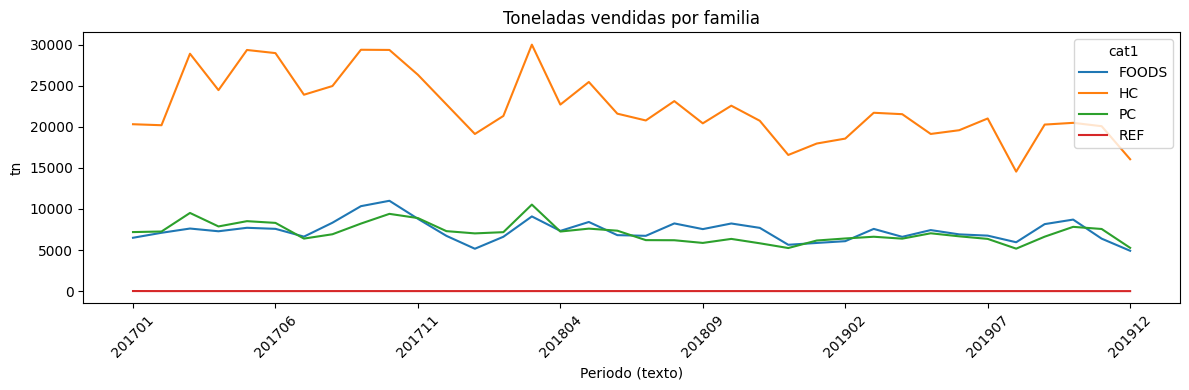

In [4]:

agg_family = df_all.groupby(['periodo', 'cat1'], observed=True)['tn'].sum().reset_index()
pivot = agg_family.pivot(index='periodo', columns='cat1', values='tn')
pivot.plot(figsize=(12, 4))
plt.title('Toneladas vendidas por familia')
plt.ylabel('tn')
plt.xlabel('Periodo (texto)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Análisis Bottom-Up: Clasificación ABC-XYZ
Evaluamos la importancia y la variabilidad de cada SKU para entender cuáles son estratégicos y estables.

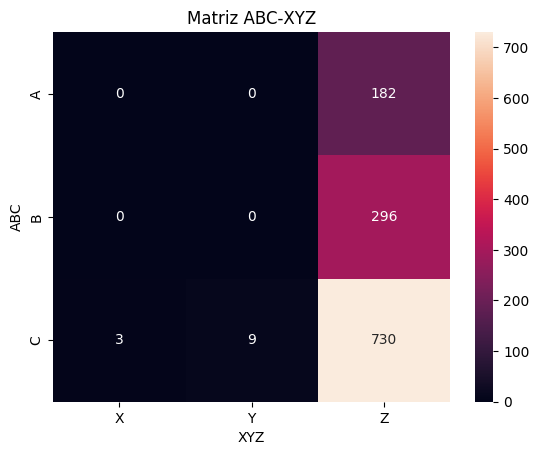

In [5]:

sku_tot = df_all.groupby('product_id')['tn'].sum().sort_values(ascending=False)
cum_pct = sku_tot.cumsum() / sku_tot.sum()
abc_class = pd.cut(cum_pct, bins=[0, .8, .95, 1], labels=list('ABC'))
cov = df_all.groupby('product_id')['tn'].apply(lambda x: x.std()/x.mean() if x.mean()!=0 else np.nan)
xyz_class = pd.cut(cov, bins=[-np.inf, .5, 1, np.inf], labels=list('XYZ'))

abc_df = pd.DataFrame({'total_tn': sku_tot, 'cum_pct': cum_pct, 'ABC': abc_class, 'XYZ': xyz_class})
sns.heatmap(pd.crosstab(abc_df['ABC'], abc_df['XYZ']), annot=True, fmt='d')
plt.title('Matriz ABC‑XYZ')
plt.show()


## Visualización: Volumen vs. Variabilidad de SKU
Usamos la misma clasificación ABC basada en acumulado de volumen para identificar SKU prioritarios para el modelado.

In [6]:

df_cv = df_all.groupby('product_id')['tn'].apply(lambda x: x.std()/x.mean() if x.mean()!=0 else None)
df_stats = pd.concat([sku_tot.rename("total_tn"), df_cv.rename("cv"), abc_class.rename("ABC")], axis=1).dropna()

fig = px.scatter(df_stats, x='total_tn', y='cv', color='ABC',
                 hover_name=df_stats.index.astype(str),
                 log_x=True, height=500,
                 title='Dispersión: Volumen total vs. Volatilidad (CV)',
                 labels={'total_tn': 'Toneladas Totales (log)', 'cv': 'Coef. Variación'})
fig.show()


## Análisis de clientes (customer_id)
Estudiamos el comportamiento de compra por cliente para identificar perfiles estables, erráticos, y patrones de fidelidad.

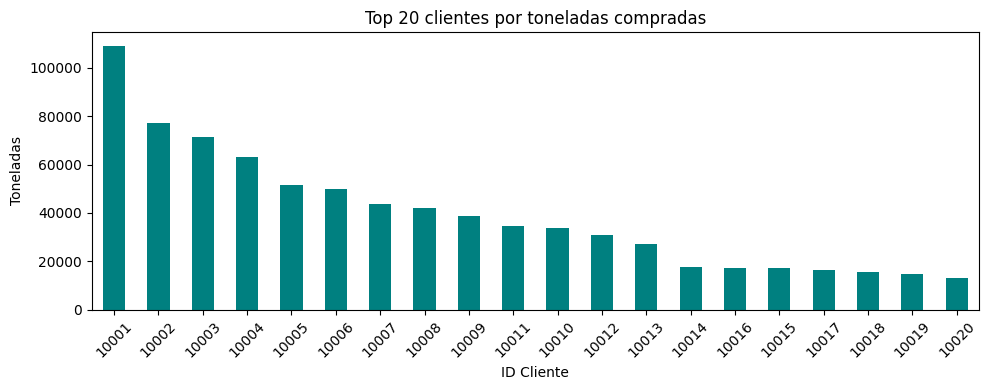

In [7]:

clientes_top = df_all.groupby('customer_id')['tn'].sum().sort_values(ascending=False).head(20)
clientes_top.plot(kind='bar', figsize=(10,4), color='teal')
plt.title('Top 20 clientes por toneladas compradas')
plt.ylabel('Toneladas')
plt.xlabel('ID Cliente')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [8]:

pivot_clientes = df_all.pivot_table(index='periodo', columns='customer_id', values='tn', aggfunc='sum', fill_value=0)

@interact(cliente=sorted(pivot_clientes.columns))
def grafico_cliente(cliente):
    pivot_clientes[cliente].plot(figsize=(10,3))
    plt.title(f'Evolución mensual de compras - Cliente {cliente}')
    plt.ylabel('Toneladas')
    plt.xlabel('Periodo')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


interactive(children=(Dropdown(description='cliente', options=(10001, 10002, 10003, 10004, 10005, 10006, 10007…

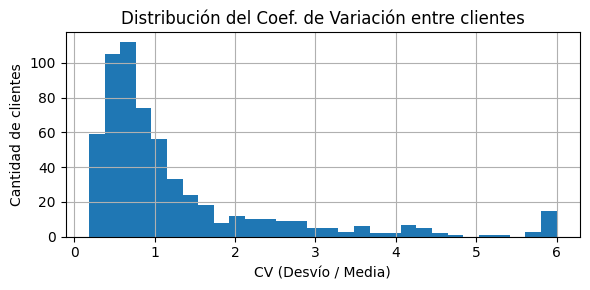

In [9]:

cv_clientes = pivot_clientes.std() / pivot_clientes.mean()
cv_clientes = cv_clientes.replace([np.inf, -np.inf], np.nan).dropna()

cv_clientes.hist(bins=30, figsize=(6,3))
plt.title('Distribución del Coef. de Variación entre clientes')
plt.xlabel('CV (Desvío / Media)')
plt.ylabel('Cantidad de clientes')
plt.grid(True)
plt.tight_layout()
plt.show()


## Volumen vs. variabilidad en clientes

In [10]:

volumen_clientes = pivot_clientes.sum()
df_clientes = pd.DataFrame({'total_tn': volumen_clientes, 'cv': cv_clientes}).dropna()

fig = px.scatter(df_clientes,
                 x='total_tn', y='cv',
                 hover_name=df_clientes.index.astype(str),
                 log_x=True,
                 labels={'total_tn': 'Toneladas totales (log)', 'cv': 'Coef. Variación'},
                 title='Dispersión: Volumen total vs. Variabilidad de compras (clientes)',
                 height=500)
fig.show()
